# Дипломная работа

<a id='0'></a> 
## Оглавление
**Постановка задачи**    
<a href='#7'> **Уточнение бизнес-постановки и Выбор метрик**     
<a href='#2'> **Описание датасета**   
<a href='#3'> **Импорт библиотек и чтение исходных данных**      
<a href='#4'> **Используемые функции**  
<a href='#5'> **Получение данных и создание новых признаков**     
    
**Исследование данных**    
<a href='#1'> **Описание структуры**     
<a href='#6'> **Статистический анализ данных**     

## Постановка задачи

Построить рекомендательную систему, располагающуюся на главной странице сайта компании-ритейлера.
Сервис должен выдавать рекомендации по id-пользователя и должен помочь повысить прибыль от продаж в интернет-магазине хотя бы на 20 %

<a id='7'></a> 
### Уточнение бизнес-постановки и Выбор метрик
<a href='#0'> *Вернуться к оглавлению*

Рекомендательная система из товаров, имеющихся в доступности, выбирает 3 с наибольшим рейтингом для данного покупателя и предлагает их покупателю.

Среди offline - метрик для определения качества модели остановимся на 

$$ Precision@N = {{К} \over {N}},$$

$$\  где\ N\ -\ количество\ рекомендованных\ товаров,\
K - количество\ купленных\ товаров\ из\ рекомендованных $$

и Mean Reciprocal Rank для оценки качества ранжирования:

$$ E({{1} \over {pos}}),$$
$$ на\ какой\ позиции\ списка\ рекомендаций\ пользователь\ находит\ первую\ полезную$$

Для бизнеса в данном случае интересными метриками могут оказаться: 
- конверсия товара в корзину, 
- конверсия товара в покупку, 
- средняя длина конверсии от просмотра товара до совершения покупки.

Но в данном конкретном случае основной метрикой будет прибыль от продаж.
Но для вычисления данной метрики уже после вывода в продашн потребуется знать себестоимость продаваемых товаров, а не просто выручку.

<a id='2'></a> 
### Описание датасета
<a href='#0'> *Вернуться к оглавлению*

**events** — датасет с событиями. 

Колонки:

- timestamp — время события
- visitorid — идентификатор пользователя
- event — тип события
- itemid — идентификатор объекта
- transactionid — идентификатор транзакции, если она проходила

Записей событий - 2756101

Типы событий:

- view (просмотр карточки товара
- addtocart (добавление в корзину)
- transaction (покупка)


**category_tree** — файл с деревом категорий (можно восстановить дерево).

- category_id — идентификатор категорий
- parent_id — идентификатор родительской категории

**item_properties** — файл с свойствами товаров.

- timestamp — момент записи значения свойства
- item_id — идентификатор объекта
- property — свойство, кажется, они все, кроме категории, захешированы
- value — значение свойства

Уникальных признаков товара   1104

<a id='3'></a> 
### Импорт библиотек
<a href='#0'> *Вернуться к оглавлению*

In [1]:
# импортируем необходимые библиотеки
import datetime
import numpy as np
import pandas as pd
import os
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import OrdinalEncoder
from implicit.als import AlternatingLeastSquares
from implicit.evaluation import mean_average_precision_at_k
from sklearn import metrics
from sklearn.cluster import KMeans

from gensim.models import Word2Vec
from sklearn.manifold import TSNE

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, StratifiedKFold

%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
path = r'F:\SkillFactory\diplom'

In [186]:
# загрузим данные
category = pd.read_csv(os.path.join(path,'category_tree.csv'))
events = pd.read_csv(os.path.join(path,'events.csv'))
items1 = pd.read_csv(os.path.join(path,'item_properties_part1.csv'))
items2 = pd.read_csv(os.path.join(path,'item_properties_part2.csv'))

<a id='4'></a> 
### Используемые функции
<a href='#0'> *Вернуться к оглавлению*

In [4]:
def features_from_data(df, timestamp):
    '''
    Новые признаки из поля datetime
    
    df - Data Frame
    timestamp - name of column to transform new features
    
    '''
    dat = pd.to_datetime(df[timestamp], unit='ms', origin='unix')
    #df['date0'] = dat
    df['date'] = dat.dt.date
    df['hour'] = dat.dt.hour.astype('int8')
    df['month'] = dat.dt.month.astype('int8')
    df['doy'] = dat.dt.dayofyear.astype('int32')
    #df['year'] = dat.dt.year.astype('int16')
    df['weekofyear'] = dat.dt.isocalendar().week.astype('int8')
    df['dow'] = dat.dt.dayofweek.astype('int8')

In [5]:
def show_distination(df, _list, target):
    '''
    Изображает распределение признаков и боксплоты с выбросами по значениям целевой функции
    '''
    len_list = len(_list)
    length = 16
    if len_list<4:
        length = 4*len_list
    fig, axs = plt.subplots(2,len_list, constrained_layout=True, figsize=(length, 5))
    
    for i in range(len_list):
        
        df[_list[i]].hist(ax=axs[0,i])
        df.boxplot(column=[_list[i]], by=target, ax=axs[1,i])

In [6]:
def create_df_feature(code_property, _type):
    '''
    Создает датафрейм для добавления к данным по коду свойства
    '''
    new_df = properties[properties['property']==code_property][['itemid','weekofyear', 'value']]
    if code_property == '790': # price
        new_df['value'] = new_df['value'].apply(lambda x: x[1:])
        new_df['value'] = new_df['value'].astype('float')
    new_df['value'] = new_df['value'].astype(_type)
    
    # Свойства устанавливаются на следующую неделю:
    new_df['weekofyear'] = new_df['weekofyear'] + 1 

    return new_df

In [7]:
def iqd(df, col):
    '''
    interquartile distance formula
    '''
    IQR = df[col].quantile(0.75) - df[col].quantile(0.25)
    perc25 = df[col].quantile(0.25)
    perc75 = df[col].quantile(0.75)

    print(
    '25-й перцентиль: {},'.format(perc25),
    '75-й перцентиль: {},'.format(perc75),
    "IQR: {}, ".format(IQR),
    "Границы выбросов: [{f}, {l}].".format(f=perc25 - 1.5*IQR, l=perc75 + 1.5*IQR))
    return 
    
    
def show_correlation(df, features):
    '''
    plot correlation matrix
    '''
    
    #corr_matrix = df.drop(categorial_feature, axis=1).corr()
    corr_matrix = df[features].corr()
    plt.rcParams['figure.figsize'] = (15,15)
    sns.heatmap(corr_matrix, square=True,
                annot=True, fmt=".1f", linewidths=0.1, cmap="RdBu");
    plt.tight_layout()
    
def get_boxplot(df, column, _target):
    '''
    plot boxes for the column
    '''
    fig, ax = plt.subplots(figsize = (14, 4))
    sns.boxplot(x=column, y=_target,data=df, ax=ax) 
    plt.xticks(rotation=45)
    ax.set_title('Boxplot for ' + column)
    plt.show()
    

In [8]:
def display_data(dataframe, list_columns=None):
    '''
    Развернутая информация по датасету с фильтрацией по списку колонок,
    по умолчнию без фильтрации,
    названия признаков упорядочены по алфавиту
    '''
    if list_columns==None:
        index_ = sorted(dataframe.columns)
    else: 
        index_ = sorted([x for x in set(dataframe.dtypes.index).intersection(set(list_columns))])
    
    df = dataframe[index_]
    d = pd.concat([df.dtypes,df.count() + df.isna().sum(),\
               round((df.isna().sum()/(df.count() + df.isna().sum()))*100,2),df.nunique(),],axis=1)
    d.columns = ['Тип', 'Общ.кол', '% пропусков','Кол-во уник.значений']
    display(d)
    
    return

In [9]:
# Наивный подход к созданию единого эмбеддинга для документа – средний эмбеддинг по словам
def doc_vectorizer(doc, model):
    doc_vector = []
    num_words = 0
    for word in doc:
        try:
            if num_words == 0:
                doc_vector = model.wv[word]
            else:
                doc_vector = np.add(doc_vector, model.wv[word])
            num_words += 1
        except:
            pass
     
    return np.asarray(doc_vector) / num_words


<a id='5'></a> 
## Получение данных и создание новых признаков
<a href='#0'> *Вернуться к оглавлению*

При подготовке данных постараемся уменьшить размер используемой памяти путем преобразования типов данных, посмотрим на уникальность данных,
датасеты свойств объединим в один, определим ключевые поля для связи между датасетами, а также получим новые признаки из поля timestamp

### Предварительное исследование данных

**Category**

In [10]:
category.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1669 entries, 0 to 1668
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   categoryid  1669 non-null   int64  
 1   parentid    1644 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 26.2 KB


In [11]:
print('Количество уникальных значений категорий - {} и родительских категорий - {}'.\
      format(category.categoryid.nunique(), category.parentid.nunique()))

Количество уникальных значений категорий - 1669 и родительских категорий - 362


In [12]:
# Заменим неопределенные значения 'parentid' на -1, это корень дерева
category['parentid'].fillna(-1, inplace=True)

In [13]:
# Количество ветвей, выходящих из корня дерева:
len(category[category.parentid==-1])

25

In [14]:
# Уменьшаем размерность данных
category['categoryid'] = category['categoryid'].astype('int32')
category['parentid'] = category['parentid'].astype('int32')

In [15]:
category.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1669 entries, 0 to 1668
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   categoryid  1669 non-null   int32
 1   parentid    1669 non-null   int32
dtypes: int32(2)
memory usage: 13.2 KB


**Events**

In [187]:
events.describe()

,timestamp,visitorid,itemid,transactionid
count,2.756101e+06,2.756101e+06,2.756101e+06,22457.000000
mean,1.436424e+12,7.019229e+05,2.349225e+05,8826.497796
std,3.366312e+09,4.056875e+05,1.341954e+05,5098.996290
min,1.430622e+12,0.000000e+00,3.000000e+00,0.000000
25%,1.433478e+12,3.505660e+05,1.181200e+05,4411.000000
50%,1.436453e+12,7.020600e+05,2.360670e+05,8813.000000
75%,1.439225e+12,1.053437e+06,3.507150e+05,13224.000000
max,1.442545e+12,1.407579e+06,4.668670e+05,17671.000000


In [188]:
events.head(5)

,timestamp,visitorid,event,itemid,transactionid
0,1433221332117,257597,view,355908,NaN
1,1433224214164,992329,view,248676,NaN
2,1433221999827,111016,view,318965,NaN
3,1433221955914,483717,view,253185,NaN
4,1433221337106,951259,view,367447,NaN


In [189]:
events.event.isna().sum()

0

##### Какой процент продаж обеспечивают топовые товары (точка отсечения — 1 июля)? 

Если мы всем будем рекомендовать топовые товары (по числу транзакций), то какое качество рекомендаций получится?

Посчитаем такую штуку: возьмём статистику до 1 июля включительно и потом прикинем, как эти товары покупались после 1 июля. Сколько процентов покупок мы можем так покрыть?

In [190]:
# Проверяем, что здесь только транзакции, т.е покупок было 22457
events[events['transactionid']>-1]['event'].unique()

array(['transaction'], dtype=object)

In [191]:
events[events['transactionid']>-1]['itemid'].value_counts()[:10]

461686    133
119736     97
213834     92
312728     46
7943       46
445351     45
48030      41
420960     38
248455     38
17478      37
Name: itemid, dtype: int64

Три топовых товара покупали > 90 раз

In [192]:
events[events['transactionid']>-1]['itemid'].value_counts()[:3].sum()

322

In [193]:
events[events['transactionid']>-1]['itemid'].value_counts()[3:].sum()

22135

In [194]:
print('Если смотреть на весь датасет, то три топовых продукта составляют {:5.2} % от всех продаж'.\
      format(events[events['transactionid']>-1]['itemid'].value_counts()[:3].sum()*100/\
            (events[events['transactionid']>-1]['itemid'].value_counts()[:3].sum()+\
            events[events['transactionid']>-1]['itemid'].value_counts()[3:].sum())))

Если смотреть на весь датасет, то три топовых продукта составляют   1.4 % от всех продаж


Использовав 1 июля, как точку отсечения между двумя частями выборки для определения трех топовых продуктов по числу продаж и для непосредственного вычисления статистики получим:

In [195]:
# Получим признаки из даты
features_from_data(events, 'timestamp')

In [196]:
a = events[events.date<datetime.date(2015,7,2)].copy()
b = events[events.date>datetime.date(2015,7,1)].copy()
top3 = a[a['transactionid']>-1]['itemid'].value_counts()[:3]
top3

119736    36
369447    31
7943      30
Name: itemid, dtype: int64

In [197]:
# ТОповые продажи
b[(b['transactionid']>-1)&((b['itemid']==119736)|(b['itemid']==7943)|(b['itemid']==369447))]['itemid'].value_counts().sum()
# Все продажи на исследуемой части выборки:
b[(b['transactionid']>-1)]['itemid'].value_counts().sum()
print('Топовые товары обеспечивают только {} % продаж'.format(round(7700/(12608),2)))

Топовые товары обеспечивают только 0.61 % продаж


Полученный результат, говорит о том, что ориентироваться только на продажи топовых продуктов недостаточно. Необходимо проявить большую гибкость и исследовать предпочтения каждого покупателя отдельно.

In [198]:
events[events['transactionid']>-1].groupby(['visitorid'])[['itemid']].agg(['count'])

,itemid
,count
visitorid,
172,2
186,1
264,2
419,1
539,1
...,...
1406787,1
1406981,1


<AxesSubplot:>

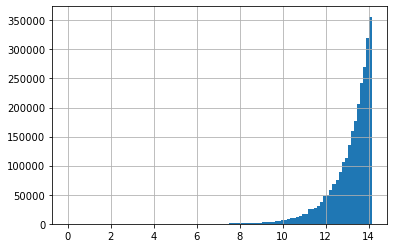

In [199]:
np.log(events['visitorid']+1).hist(bins=100)

In [200]:
events.event.unique()

array(['view', 'addtocart', 'transaction'], dtype=object)

view           2664312
addtocart        69332
transaction      22457
Name: event, dtype: int64

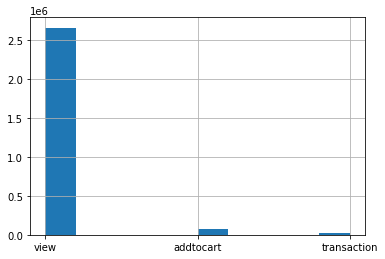

In [201]:
# Гистограмма событий
events["event"].hist()
events["event"].value_counts()

Нас будут интересовать только товары, которые покупались хотя бы один раз. Какой интерес предлагать товар, который заведомо не будет куплен? Таких записей 22457

In [202]:
#Сформируем датафрейм с покупаемыми товарами

ind = events[events.event=='transaction'].itemid.tolist() # список покупаемых товаров
df = events.loc[events.itemid.isin(ind)].copy()
df.head(10)

,timestamp,visitorid,event,itemid,transactionid,date,hour,month,doy,weekofyear,dow
1,1433224214164,992329,view,248676,NaN,2015-06-02,5,6,153,23,1
4,1433221337106,951259,view,367447,NaN,2015-06-02,5,6,153,23,1
6,1433221923240,810725,view,443030,NaN,2015-06-02,5,6,153,23,1
7,1433223291897,794181,view,439202,NaN,2015-06-02,5,6,153,23,1
10,1433222162373,176446,view,10572,NaN,2015-06-02,5,6,153,23,1
15,1433222531378,57036,view,334662,NaN,2015-06-02,5,6,153,23,1
17,1433223236124,287857,addtocart,5206,NaN,2015-06-02,5,6,153,23,1
19,1433221078505,158090,addtocart,10572,NaN,2015-06-02,4,6,153,23,1
22,1433221274809,1213673,view,343861,NaN,2015-06-02,5,6,153,23,1
27,1433222147345,1076270,view,262799,NaN,2015-06-02,5,6,153,23,1


view           842836
addtocart       48764
transaction     22457
Name: event, dtype: int64

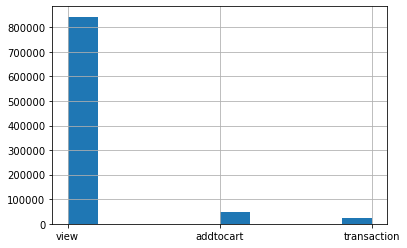

In [203]:
# Гистограмма событий
df["event"].hist()
df["event"].value_counts()

In [204]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 914057 entries, 1 to 2756098
Data columns (total 11 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   timestamp      914057 non-null  int64  
 1   visitorid      914057 non-null  int64  
 2   event          914057 non-null  object 
 3   itemid         914057 non-null  int64  
 4   transactionid  22457 non-null   float64
 5   date           914057 non-null  object 
 6   hour           914057 non-null  int8   
 7   month          914057 non-null  int8   
 8   doy            914057 non-null  int32  
 9   weekofyear     914057 non-null  int8   
 10  dow            914057 non-null  int8   
dtypes: float64(1), int32(1), int64(3), int8(4), object(2)
memory usage: 55.8+ MB


In [205]:
df['event'].value_counts()

view           842836
addtocart       48764
transaction     22457
Name: event, dtype: int64

In [206]:
# Кодируем категориальный признак типа событий:
# 1 - добавили в корзину
# 2 - покупка

df['eventid'] = 0
df['eventid'] = np.where(df['event']=='addtocart',1,0)
df['eventid'] = np.where(df['event']=='transaction',2,df['eventid'])
df['eventid'] = df['eventid'].astype('int8')

In [207]:
# Проверка кодирования
df['eventid'].value_counts()

0    842836
1     48764
2     22457
Name: eventid, dtype: int64

In [208]:
# Записываем датафрейм в файл с рейтингами
#df[['timestamp','visitorid','itemid','eventid']].to_csv(os.path.join(path,'ratings.csv'))

In [209]:
df.itemid.nunique(), df.timestamp.nunique(), df.visitorid.nunique()

(12025, 911288, 409322)

In [210]:
df['itemid'].value_counts()

461686    2978
219512    1800
257040    1647
309778    1628
384302    1608
          ... 
72462        2
159562       2
207791       2
136034       2
280270       1
Name: itemid, Length: 12025, dtype: int64

<AxesSubplot:>

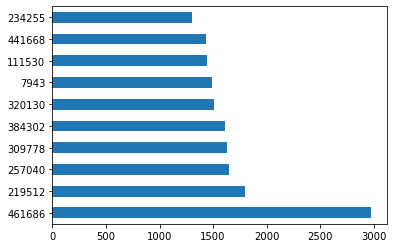

In [211]:
# Гистограмма самых популярных товаров
df['itemid'].value_counts()[:10].plot(kind='barh')

<AxesSubplot:>

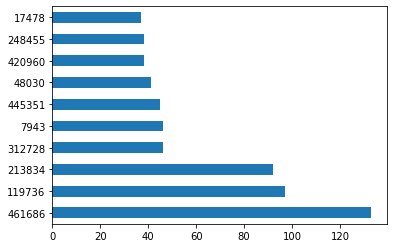

In [212]:
# Гистограмма самых продаваемых товаров
df[df.event=='transaction']['itemid'].value_counts()[:10].plot(kind='barh')

Самые популярные товары могут не входить в топ самых покупаемых товаров!

<AxesSubplot:>

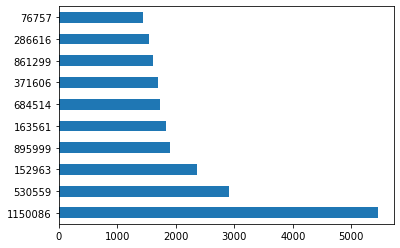

In [213]:
# Гистограмма самых "активных" покупателей 
df['visitorid'].value_counts()[:10].plot(kind='barh')

<AxesSubplot:>

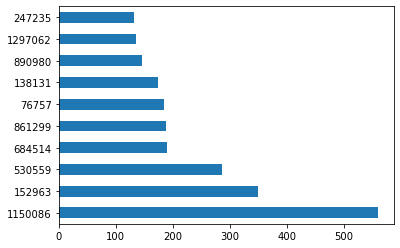

In [214]:
# Кто больше всего покупает?
df[df.event=='transaction']['visitorid'].value_counts()[:10].plot(kind='barh')

In [215]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 914057 entries, 1 to 2756098
Data columns (total 12 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   timestamp      914057 non-null  int64  
 1   visitorid      914057 non-null  int64  
 2   event          914057 non-null  object 
 3   itemid         914057 non-null  int64  
 4   transactionid  22457 non-null   float64
 5   date           914057 non-null  object 
 6   hour           914057 non-null  int8   
 7   month          914057 non-null  int8   
 8   doy            914057 non-null  int32  
 9   weekofyear     914057 non-null  int8   
 10  dow            914057 non-null  int8   
 11  eventid        914057 non-null  int8   
dtypes: float64(1), int32(1), int64(3), int8(5), object(2)
memory usage: 56.7+ MB


**Properties**

In [216]:
items1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10999999 entries, 0 to 10999998
Data columns (total 4 columns):
 #   Column     Dtype 
---  ------     ----- 
 0   timestamp  int64 
 1   itemid     int64 
 2   property   object
 3   value      object
dtypes: int64(2), object(2)
memory usage: 335.7+ MB


In [217]:
items2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9275903 entries, 0 to 9275902
Data columns (total 4 columns):
 #   Column     Dtype 
---  ------     ----- 
 0   timestamp  int64 
 1   itemid     int64 
 2   property   object
 3   value      object
dtypes: int64(2), object(2)
memory usage: 283.1+ MB


In [218]:
items1.timestamp.nunique(),items1.itemid.nunique(),items1.property.nunique()

(18, 417053, 1097)

In [219]:
items2.timestamp.nunique(),items2.itemid.nunique(),items2.property.nunique()

(18, 417053, 1094)

In [220]:
#Объединяем свойства в один датасет:
properties = pd.concat([items1,items2])

In [221]:
#Обращаем внимание, что itemid в properties - это не categoryid!!!
properties.head(5)

,timestamp,itemid,property,value
0,1435460400000,460429,categoryid,1338
1,1441508400000,206783,888,1116713 960601 n277.200
2,1439089200000,395014,400,n552.000 639502 n720.000 424566
3,1431226800000,59481,790,n15360.000
4,1431831600000,156781,917,828513


In [222]:
print('За все время только {} раз были установлены  {} уникальных значений свойств для {} товаров'\
      .format(properties.timestamp.nunique(),properties.property.nunique(), properties.itemid.nunique()))

За все время только 18 раз были установлены  1104 уникальных значений свойств для 417053 товаров


In [223]:
properties.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20275902 entries, 0 to 9275902
Data columns (total 4 columns):
 #   Column     Dtype 
---  ------     ----- 
 0   timestamp  int64 
 1   itemid     int64 
 2   property   object
 3   value      object
dtypes: int64(2), object(2)
memory usage: 773.5+ MB


In [224]:
#Сформируем датафрейм с покупаемыми товарами
properties = properties.loc[properties.itemid.isin(ind)].copy()

In [225]:
properties.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 846698 entries, 27 to 9275901
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   timestamp  846698 non-null  int64 
 1   itemid     846698 non-null  int64 
 2   property   846698 non-null  object
 3   value      846698 non-null  object
dtypes: int64(2), object(2)
memory usage: 32.3+ MB


In [226]:
print('За все время только {} раз были установлены  {} уникальных значений свойств для {} товаров'\
      .format(properties.timestamp.nunique(),properties.property.nunique(), properties.itemid.nunique()))

За все время только 18 раз были установлены  936 уникальных значений свойств для 11645 товаров


In [227]:
# Уменьшаем размерность данных
#properties['timestamp'] = properties['timestamp'].astype('int32')
properties['itemid'] = properties['itemid'].astype('int32')

In [228]:
properties.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 846698 entries, 27 to 9275901
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   timestamp  846698 non-null  int64 
 1   itemid     846698 non-null  int32 
 2   property   846698 non-null  object
 3   value      846698 non-null  object
dtypes: int32(1), int64(1), object(2)
memory usage: 29.1+ MB


<AxesSubplot:>

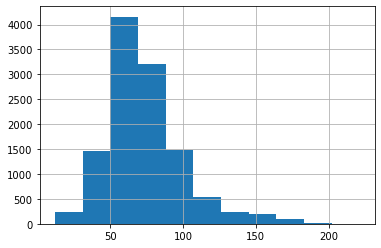

In [229]:
properties['itemid'].value_counts().hist(bins=11)

In [230]:
properties['property'].value_counts()[:10] #936 для продаваемых товаров, а не 1104

790           190841
available     144620
888           105279
categoryid     23809
776            16747
283            16507
364            14092
400            13623
202            12953
6              12805
Name: property, dtype: int64

In [231]:
# Сформируем список наиболее важных наиболее распространенных свойств
list_properties = properties['property'].value_counts()[:10].index.tolist()
list_properties

['790',
 'available',
 '888',
 'categoryid',
 '776',
 '283',
 '364',
 '400',
 '202',
 '6']

In [232]:
properties[properties['property']=='790']['value'][:5]

145    n400080.000
258    n273000.000
264    n238800.000
496     n22320.000
510    n122760.000
Name: value, dtype: object

In [233]:
properties[properties['property']=='available']['value'][:5]

119    0
296    1
444    1
463    1
542    1
Name: value, dtype: object

In [234]:
properties[properties['property']=='888']['value'][:5]

104          1333963 747375 927741 1071593 547687 199524
139    722389 543387 679871 n180.000 1175087 n144.000...
446                                               980463
794                                               914786
906                                               488331
Name: value, dtype: object

По частоте испотзования свойств мы видим первые 3( > 100000)

 - 790 - это числовое поле, цена
 - available - доступность товара
 - 888 - хэш

In [235]:
#888
prop = list_properties[2]
properties[properties['property']==prop]['value'].value_counts()

127030                              83
150169 727528 20836 624616 99315    53
172002 1045165 1018845              36
109135                              36
888666 556040                       34
                                    ..
166198 46534                         1
1326469                              1
62410                                1
797168                               1
516870 n7620.000 1007509             1
Name: value, Length: 17238, dtype: int64

In [236]:
docs = properties[properties['property']==prop]['value'].value_counts()[:].index.tolist()
#docs = [x.split(sep=' ') for x in docs]
#docs[2]

In [237]:
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(docs)

In [238]:
X

<17238x14967 sparse matrix of type '<class 'numpy.float64'>'
	with 74337 stored elements in Compressed Sparse Row format>

In [239]:
X.shape

(17238, 14967)

In [240]:
# Создаём KMeans кластеризатор 
kmeans = KMeans(n_clusters=8)

# Обучим кластеризатор на подготовленных данных
kmeans.fit(X)

# Получаем предсказанные кластеры
y_pred = kmeans.labels_.astype(int)


In [241]:
len(y_pred), type(y_pred),type(X)

(17238, numpy.ndarray, scipy.sparse.csr.csr_matrix)

In [242]:
#properties[properties['property']==prop]['value'].value_counts().index.tolist()

In [243]:
pd.DataFrame(y_pred)[0].value_counts()

3    12436
1     1328
5     1087
4      862
0      734
7      373
6      219
2      199
Name: 0, dtype: int64

In [244]:
# Запомним результат модели в словаре с ключами со значениями исходного поля
dict_clasters = dict(zip(docs, y_pred))

In [245]:
# Доступность товара в течение периода
# При рекомендации товара необходимо учитывать его доступность и замену аналогом
properties[properties['property']=='available']['value'].unique()

array(['0', '1'], dtype=object)

In [246]:
properties[properties['property']=='available']['value'].value_counts()

1    90104
0    54516
Name: value, dtype: int64

In [247]:
print('{} значения categoryid из {} используются в properties'.\
      format(properties[properties['property']=='categoryid']['value'].nunique(),\
            category.categoryid.nunique()))

751 значения categoryid из 1669 используются в properties


In [248]:
# Получим признаки из даты
features_from_data(properties, 'timestamp')
properties = properties.drop(columns='timestamp')

In [249]:
# Поскольку значение одно колонку можно удалить
#properties['year'].value_counts()
#2015
# Рассмотрим уникальность hour & dow
properties['hour'].value_counts(), properties['dow'].value_counts()

(3    846698
 Name: hour, dtype: int64,
 6    846698
 Name: dow, dtype: int64)

Можно сделать вывод, что установка свойств, а особенно важного для нас свойства, как цена,
происходит в 6-ой день недели (воскресенье) в 3 часа. Т.е свойства задаются 1 раз в конце недели и действуют в течение следующей недели (weekofyear). Поскольку год только 2015, weekofyear будет однозначно определять уникальные признаки продаваемого товара в течение недели.

In [250]:
display_data(properties)

,Тип,Общ.кол,% пропусков,Кол-во уник.значений
date,object,846698,0.0,18
dow,int8,846698,0.0,1
doy,int32,846698,0.0,18
hour,int8,846698,0.0,1
itemid,int32,846698,0.0,11645
month,int8,846698,0.0,5
property,object,846698,0.0,936
value,object,846698,0.0,81051
weekofyear,int8,846698,0.0,18


In [251]:
features_from_data(df, 'timestamp')
#Удаляем признак 
df = df.drop(columns='timestamp')

In [252]:
# Заменим неопределенные значения 'transactionid' 
df['transactionid'].fillna(-1, inplace=True)

In [253]:
for col in ['visitorid', 'itemid', 'transactionid']:
    df[col] = df[col].astype('int32')

In [254]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 914057 entries, 1 to 2756098
Data columns (total 11 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   visitorid      914057 non-null  int32 
 1   event          914057 non-null  object
 2   itemid         914057 non-null  int32 
 3   transactionid  914057 non-null  int32 
 4   date           914057 non-null  object
 5   hour           914057 non-null  int8  
 6   month          914057 non-null  int8  
 7   doy            914057 non-null  int32 
 8   weekofyear     914057 non-null  int8  
 9   dow            914057 non-null  int8  
 10  eventid        914057 non-null  int8  
dtypes: int32(4), int8(5), object(2)
memory usage: 39.2+ MB


In [255]:
#df[df.visitorid==121688]

In [256]:
# Количество позиций в чеке
dict_check = df.groupby(df['transactionid'])['transactionid'].count().to_dict()
df['transactionq'] = df['transactionid'].apply(lambda x: dict_check[x] if x>0 else 0)
df['transactionq'] = df['transactionq'].astype('int16')

<AxesSubplot:>

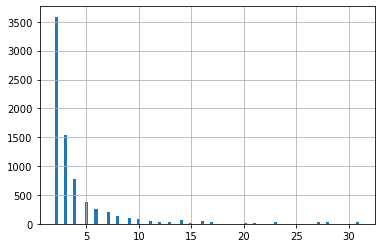

In [257]:
df[df['transactionq']>1]['transactionq'].hist(bins=100)

In [258]:
#df[df.visitorid==121688]

In [259]:
# Корректировка weekofyear для 6-го дня после 3-часов: установка свойств на следующую неделю
df['weekofyear'] = np.where((df['dow']==6)&(df['hour']>2),df['weekofyear']+1,df['weekofyear'])

# Присоединим цену
new_df = create_df_feature('790', 'int32') #price

df = pd.merge(df, new_df, on=['itemid', 'weekofyear'], how='left')
df.rename(columns = {'value': 'price'},  inplace=True)

In [260]:
# Сумма покупки в транзакции нормированная:
dict_check = df.groupby(df['transactionid'])['price'].sum().to_dict()
df['summa'] = df['transactionid'].apply(lambda x: dict_check[x] if x>0 else 0)
_diff = np.max(df['summa'])-np.min(df['summa'])
df['summa_norm'] = np.where(_diff>0, df['summa']/_diff, 0).round(2)

In [261]:
# Признак доступности товара 
new_df = create_df_feature('available', 'int8') #available

df = pd.merge(df, new_df, on=['itemid', 'weekofyear'], how='left')
df.rename(columns = {'value': 'available'},  inplace=True)

In [262]:
# Категория товара
new_df = create_df_feature('categoryid', 'int16') #available

df = pd.merge(df, new_df, on=['itemid', 'weekofyear'], how='left')
df.rename(columns = {'value': 'categoryid'},  inplace=True)


In [263]:
df

,visitorid,event,itemid,transactionid,date,hour,month,doy,weekofyear,dow,eventid,transactionq,price,summa,summa_norm,available,categoryid
0,992329,view,248676,-1,2015-06-02,5,6,153,23,1,0,0,19800.0,0.0,0.0,NaN,NaN
1,951259,view,367447,-1,2015-06-02,5,6,153,23,1,0,0,443880.0,0.0,0.0,1.0,1613.0
2,810725,view,443030,-1,2015-06-02,5,6,153,23,1,0,0,28800.0,0.0,0.0,NaN,NaN
3,794181,view,439202,-1,2015-06-02,5,6,153,23,1,0,0,23160.0,0.0,0.0,NaN,NaN
4,176446,view,10572,-1,2015-06-02,5,6,153,23,1,0,0,9180.0,0.0,0.0,1.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
914052,887677,view,415160,-1,2015-08-01,3,8,213,31,5,0,0,111480.0,0.0,0.0,1.0,NaN
914053,611270,view,432925,-1,2015-08-01,2,8,213,31,5,0,0,45000.0,0.0,0.0,0.0,NaN
914054,831605,view,57810,-1,2015-08-01,3,8,213,31,5,0,0,72240.0,0.0,0.0,1.0,NaN
914055,804736,addtocart,346534,-1,2015-08-01,3,8,213,31,5,1,0,95400.0,0.0,0.0,1.0,NaN


In [264]:
display_data(df)

,Тип,Общ.кол,% пропусков,Кол-во уник.значений
available,float64,914057,39.54,2
categoryid,float64,914057,88.50,685
date,object,914057,0.00,139
dow,int8,914057,0.00,7
doy,int32,914057,0.00,139
event,object,914057,0.00,3
eventid,int8,914057,0.00,3
hour,int8,914057,0.00,24
itemid,int32,914057,0.00,12025
month,int8,914057,0.00,5


In [265]:
df['categoryid'].fillna(0, inplace=True)
df['available'].fillna(2, inplace=True)
df['price'].fillna(0, inplace=True)

In [266]:
# Свойство888
new_df = create_df_feature('888', 'str') #available

df = pd.merge(df, new_df, on=['itemid', 'weekofyear'], how='left')
df.rename(columns = {'value': 'prop888'},  inplace=True)


In [267]:
display_data(df)

,Тип,Общ.кол,% пропусков,Кол-во уник.значений
available,float64,914057,0.00,3
categoryid,float64,914057,0.00,685
date,object,914057,0.00,139
dow,int8,914057,0.00,7
doy,int32,914057,0.00,139
event,object,914057,0.00,3
eventid,int8,914057,0.00,3
hour,int8,914057,0.00,24
itemid,int32,914057,0.00,12025
month,int8,914057,0.00,5


In [268]:
# Кластеризация 888
df['prop888'].fillna('9', inplace=True)
dict_clasters['9'] = 9
df['prop888'] = df['prop888'].apply(lambda x: dict_clasters[x])
df['prop888'] = df['prop888'].astype('int16')

# Создание датасета

In [269]:
def create_dataframe(df, dict_actions):
    
    '''
    Формирует датасет в соответствии со словарем
    dict_actions = {0:'view', 1:'addtocart', 2: 'transaction'}
    по количеству совершенных действий
    '''
    #click
    df0 = df[df.event==dict_actions[0]].groupby(['doy','visitorid','itemid',\
        'available', 'categoryid',\
        'dow', 'eventid', 'month', 'price', 'summa', 'transactionid', 'transactionq', 'weekofyear', 'prop888'])\
        .agg(
            view = pd.NamedAgg(column = 'event', aggfunc='count'),
            hour_view = pd.NamedAgg(column = 'hour', aggfunc='min'),
        )
    #df0.rename({'event':dict_actions[0]}, axis=1,inplace=True)
    i = 1
    
    df0 = df0.merge(df[df.event==dict_actions[i]].groupby(['doy','visitorid','itemid',\
        'available', 'categoryid',\
        'dow', 'eventid', 'month', 'price', 'summa', 'transactionid', 'transactionq', 'weekofyear', 'prop888'])[['event']].count(),\
        left_on=['doy','visitorid','itemid',\
        'available', 'categoryid',\
        'dow', 'eventid', 'month', 'price', 'summa', 'transactionid', 'transactionq', 'weekofyear', 'prop888'],\
                    right_on=['doy','visitorid','itemid',\
        'available', 'categoryid',\
        'dow', 'eventid', 'month', 'price', 'summa', 'transactionid', 'transactionq', 'weekofyear', 'prop888'],\
        how='outer')
    df0.rename({'event':dict_actions[i]}, axis=1,inplace=True)
        
    i = 2
    
    df0 = df0.merge(df[df.event==dict_actions[i]].groupby(['doy','visitorid','itemid',\
        'available', 'categoryid',\
        'dow', 'eventid', 'month', 'price', 'summa', 'transactionid', 'transactionq', 'weekofyear', 'prop888']).agg(\
        transaction = pd.NamedAgg(column = 'event', aggfunc='count'),
        hour_transaction = pd.NamedAgg(column = 'hour', aggfunc='max'),
        ), left_on=['doy','visitorid','itemid',\
        'available', 'categoryid',\
        'dow', 'eventid', 'month', 'price', 'summa', 'transactionid', 'transactionq', 'weekofyear', 'prop888'],\
                    right_on=['doy','visitorid','itemid',\
        'available', 'categoryid',\
        'dow', 'eventid', 'month', 'price', 'summa', 'transactionid', 'transactionq', 'weekofyear', 'prop888'],\
        how='outer')
    #df0.rename({'event':dict_actions[i]}, axis=1,inplace=True)
    
    df0 = df0.reset_index()
                
    return df0

dict_actions = {0:'view', 1:'addtocart', 2: 'transaction'}
df = create_dataframe(df, dict_actions)

In [270]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 732965 entries, 0 to 732964
Data columns (total 19 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   doy               732965 non-null  int64  
 1   visitorid         732965 non-null  int64  
 2   itemid            732965 non-null  int64  
 3   available         732965 non-null  float64
 4   categoryid        732965 non-null  float64
 5   dow               732965 non-null  int64  
 6   eventid           732965 non-null  int64  
 7   month             732965 non-null  int64  
 8   price             732965 non-null  float64
 9   summa             732965 non-null  float64
 10  transactionid     732965 non-null  int64  
 11  transactionq      732965 non-null  int64  
 12  weekofyear        732965 non-null  int64  
 13  prop888           732965 non-null  int64  
 14  view              666117 non-null  float64
 15  hour_view         666117 non-null  float64
 16  addtocart         44

In [271]:
df.head(5)

,doy,visitorid,itemid,available,categoryid,dow,eventid,month,price,summa,transactionid,transactionq,weekofyear,prop888,view,hour_view,addtocart,transaction,hour_transaction
0,123,385,47324,2.0,0.0,6,0,5,0.0,0.0,-1,0,19,9,1.0,5.0,NaN,NaN,NaN
1,123,1819,127969,2.0,0.0,6,0,5,0.0,0.0,-1,0,19,9,1.0,22.0,NaN,NaN,NaN
2,123,2231,340329,2.0,0.0,6,0,5,0.0,0.0,-1,0,19,9,1.0,22.0,NaN,NaN,NaN
3,123,2337,218126,2.0,0.0,6,0,5,0.0,0.0,-1,0,19,9,1.0,22.0,NaN,NaN,NaN
4,123,3194,277139,2.0,0.0,6,0,5,0.0,0.0,-1,0,19,9,1.0,18.0,NaN,NaN,NaN


In [272]:
# Заполняем пустые значения:
# Если товар был продан, то он был предварительно уложен в корзину
# Если товар положен в корзину, то он был предварительно просмотрен
# Остальное - нули
df['addtocart'].fillna(df['transaction'], inplace=True)
df['view'].fillna(df['addtocart'], inplace=True)
df['hour_view'].fillna(df['hour_transaction'], inplace=True)
df['addtocart'].fillna(0, inplace=True)
df['transaction'].fillna(0, inplace=True)

In [273]:
df

,doy,visitorid,itemid,available,categoryid,dow,eventid,month,price,summa,transactionid,transactionq,weekofyear,prop888,view,hour_view,addtocart,transaction,hour_transaction
0,123,385,47324,2.0,0.0,6,0,5,0.0,0.0,-1,0,19,9,1.0,5.0,0.0,0.0,NaN
1,123,1819,127969,2.0,0.0,6,0,5,0.0,0.0,-1,0,19,9,1.0,22.0,0.0,0.0,NaN
2,123,2231,340329,2.0,0.0,6,0,5,0.0,0.0,-1,0,19,9,1.0,22.0,0.0,0.0,NaN
3,123,2337,218126,2.0,0.0,6,0,5,0.0,0.0,-1,0,19,9,1.0,22.0,0.0,0.0,NaN
4,123,3194,277139,2.0,0.0,6,0,5,0.0,0.0,-1,0,19,9,1.0,18.0,0.0,0.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
732960,261,427756,342659,1.0,1177.0,4,2,9,10320.0,10320.0,13143,1,38,3,1.0,1.0,1.0,1.0,1.0
732961,261,569539,389860,1.0,0.0,4,2,9,387960.0,387960.0,11088,1,38,9,1.0,0.0,1.0,1.0,0.0
732962,261,751256,241715,1.0,0.0,4,2,9,1439880.0,1439880.0,7217,1,38,1,1.0,0.0,1.0,1.0,0.0
732963,261,1156860,367900,1.0,0.0,4,2,9,5880.0,5880.0,12697,1,38,1,1.0,0.0,1.0,1.0,0.0


1.0     617672
2.0      80250
3.0      20865
4.0       7466
5.0       3109
6.0       1580
7.0        807
8.0        446
9.0        249
10.0       156
Name: view, dtype: int64


<AxesSubplot:>

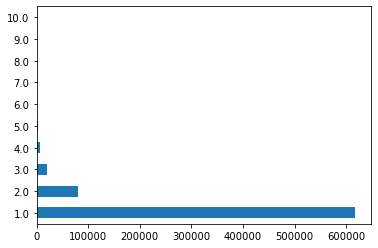

In [274]:
print(df.view.value_counts()[:10])
df.view.value_counts()[:10].plot(kind='barh')

0.0     666117
1.0      63617
2.0       2699
3.0        305
4.0        133
6.0         26
5.0         23
8.0         10
9.0          8
7.0          7
10.0         6
11.0         3
14.0         3
13.0         2
12.0         2
31.0         1
26.0         1
29.0         1
16.0         1
Name: addtocart, dtype: int64


<AxesSubplot:>

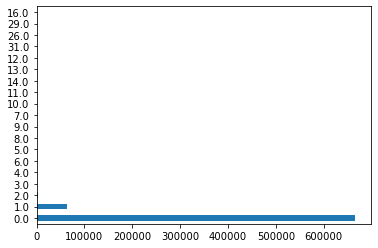

In [275]:
print(df.addtocart.value_counts())
df.addtocart.value_counts()[:].plot(kind='barh')

0.0    710639
1.0     22206
2.0       110
3.0         9
4.0         1
Name: transaction, dtype: int64


<AxesSubplot:>

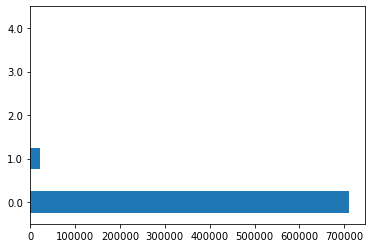

In [276]:
print(df.transaction.value_counts())
df.transaction.value_counts().plot(kind='barh')

**Для валидации будем использовать разбиение по временным интервалам: например, по неделям (weekofyear). Это возможно в силу того, что у нас данные только 2015 года.**

In [229]:
# Записываем датафрейм в файл с рейтингами
df[['doy','visitorid','itemid','rating']].to_csv(os.path.join(path,'ratings.csv'))

In [111]:
for col in dict_actions.values():
    #print(col)
    df[col] = df[col].astype('int16')

view
addtocart
transaction


In [57]:
df.describe()

,doy,visitorid,itemid,view,addtocart,transaction,rating
count,674732.000000,6.747320e+05,674732.000000,674732.000000,674732.000000,674732.000000,674732.000000
mean,189.475701,7.022659e+05,238080.363902,1.264381,0.076922,0.033283,0.409751
std,38.835430,4.049503e+05,133877.062334,0.795694,0.307865,0.186901,2.070259
min,123.000000,0.000000e+00,15.000000,1.000000,0.000000,0.000000,0.000000
25%,156.000000,3.505660e+05,122219.000000,1.000000,0.000000,0.000000,0.000000
50%,189.000000,7.037770e+05,242245.000000,1.000000,0.000000,0.000000,0.000000
75%,222.000000,1.052973e+06,352634.000000,1.000000,0.000000,0.000000,0.000000
max,261.000000,1.407578e+06,466861.000000,67.000000,31.000000,5.000000,57.000000


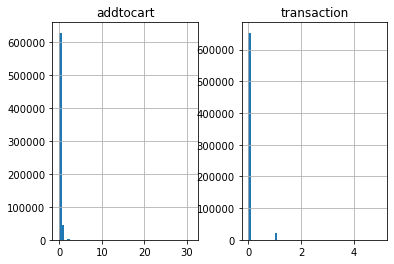

In [58]:
df[['addtocart', 'transaction']].hist(bins=50);

In [136]:
from scipy.stats import shapiro
def test_shapiro(sample, alpha, text):
    '''
    Тест Шапиро-Уилка
    sample - выборка
    alpha - 
    '''
    stat, p = shapiro(sample)
    print('Статистика=%.3f, p=%.3f' % (stat, p))
    # interpret
    
    if p > alpha:
        print(f'Выборка {text} выглядит гауссовой (не удается отклонить H0)')
    else:
        print(f'Выборка {text} не выглядит Гауссовой (отклонить H0)')

In [143]:
test_shapiro(df['addtocart'], 0.05, 'addtocart')

Статистика=0.138, p=0.000
Выборка addtocart не выглядит Гауссовой (отклонить H0)


In [144]:
test_shapiro(df['transaction'], 0.05, 'transaction')

Статистика=0.069, p=0.000
Выборка transaction не выглядит Гауссовой (отклонить H0)


In [148]:
import seaborn as sns
import matplotlib.pyplot as plt

def _kde(feature):
    '''
    Сравнение признаков по группам
    '''
    for feat in feature:
        sns.kdeplot(x=feat, data=df, common_norm=False, label=feat);
    
    plt.legend(title='features', loc='upper right')    
    plt.title("Kernel Density Function");

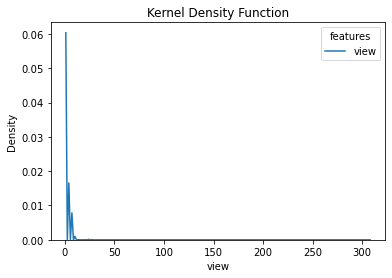

In [150]:
_kde(['view'])

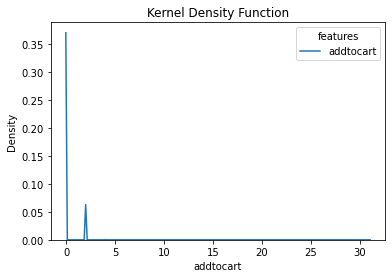

In [152]:
_kde(['addtocart'])

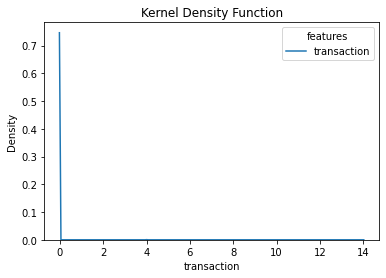

In [151]:
_kde(['transaction'])

In [188]:
# Перекодируем категориальный признак event:
ord_enc = OrdinalEncoder()
events["eventid"] = ord_enc.fit_transform(events[["event"]])

In [189]:
events["eventid"].value_counts()

2.0    2664312
0.0      69332
1.0      22457
Name: eventid, dtype: int64

In [190]:
events["eventid"] = events["eventid"].astype('int8')
events = events.drop(columns='event')

In [191]:
events.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2756101 entries, 0 to 2756100
Data columns (total 10 columns):
 #   Column         Dtype 
---  ------         ----- 
 0   visitorid      int32 
 1   itemid         int32 
 2   transactionid  int32 
 3   date           object
 4   hour           int8  
 5   month          int8  
 6   year           int16 
 7   weekofyear     int8  
 8   dow            int8  
 9   eventid        int8  
dtypes: int16(1), int32(3), int8(5), object(1)
memory usage: 71.0+ MB


In [263]:
events['itemid'].value_counts()[:2]

187946    3412
461686    2978
Name: itemid, dtype: int64

<AxesSubplot:>

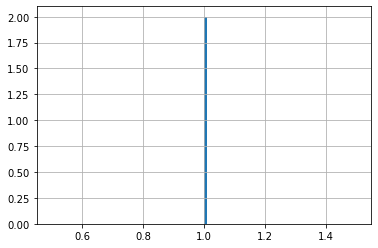

In [261]:
events.iloc[events['itemid'].value_counts()[:2].index.tolist()]['itemid'].value_counts().hist(bins=100)

## Исследование данных

<a id='1'></a> 
### Описание структуры
<a href='#0'> *Вернуться к оглавлению*

<a id='6'></a> 
### Статистический анализ данных
<a href='#0'> *Вернуться к оглавлению*

In [221]:
display_data(df)

,Тип,Общ.кол,% пропусков,Кол-во уник.значений
available,float64,914057,0.0,3
categoryid,float64,914057,0.0,685
date,object,914057,0.0,139
dow,int8,914057,0.0,7
doy,int32,914057,0.0,139
event,object,914057,0.0,3
eventid,int8,914057,0.0,3
hour,int8,914057,0.0,24
itemid,int32,914057,0.0,12025
month,int8,914057,0.0,5


In [243]:
df.transactionid.unique()

array([   -1,  4000, 11117, ...,  4385, 13872, 17579])

C:\Users\Nata\Anaconda3\envs\TimeSeries\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


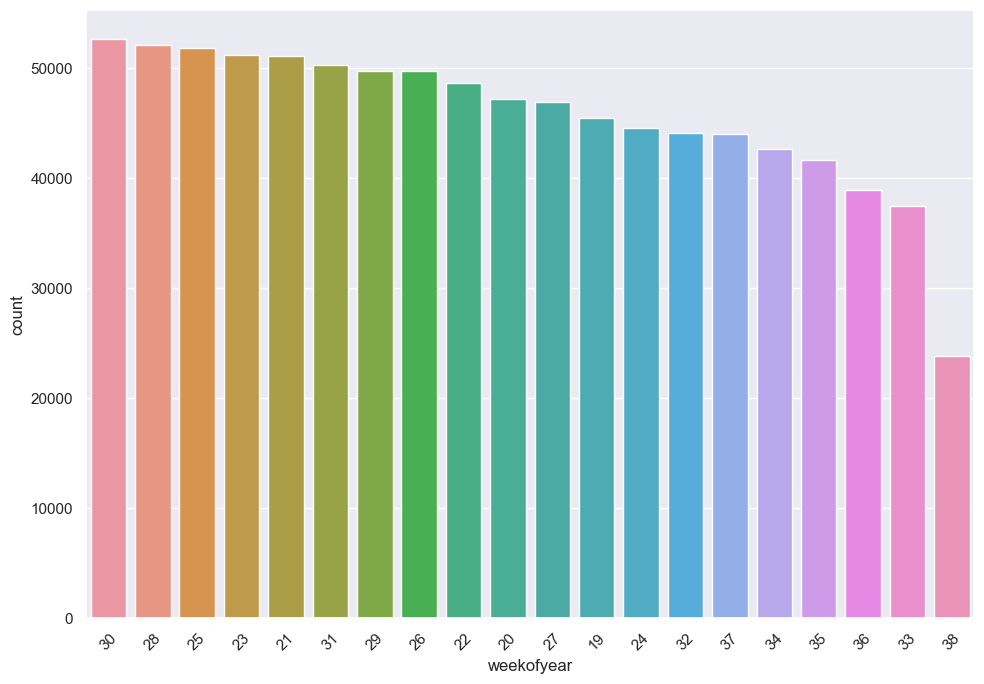

In [233]:
plt.figure(figsize=(10,7), dpi =100)
plot = sns.countplot(df['weekofyear'], order=df['weekofyear'].value_counts().index)
plot.set_xticklabels(plot.get_xticklabels(), rotation = 45)
plt.tight_layout()

C:\Users\Nata\Anaconda3\envs\TimeSeries\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


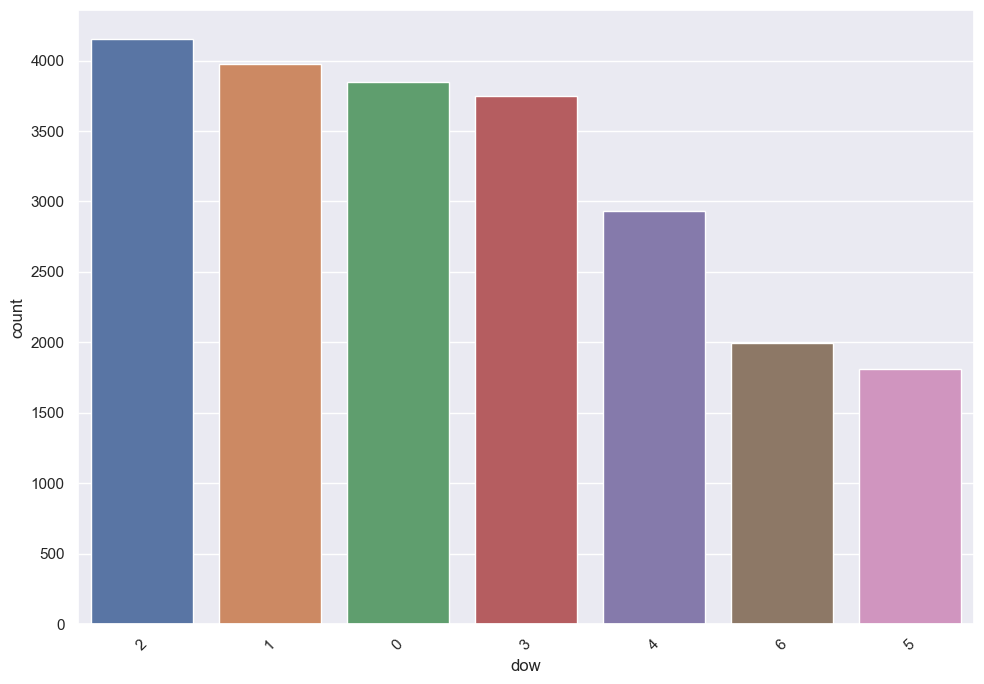

In [249]:
plt.figure(figsize=(10,7), dpi =100)
plot = sns.countplot(df[df['transactionid']>0]['dow'], order=df[df['transactionid']>0]['dow'].value_counts().index)
plot.set_xticklabels(plot.get_xticklabels(), rotation = 45)
plt.tight_layout()

C:\Users\Nata\Anaconda3\envs\TimeSeries\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


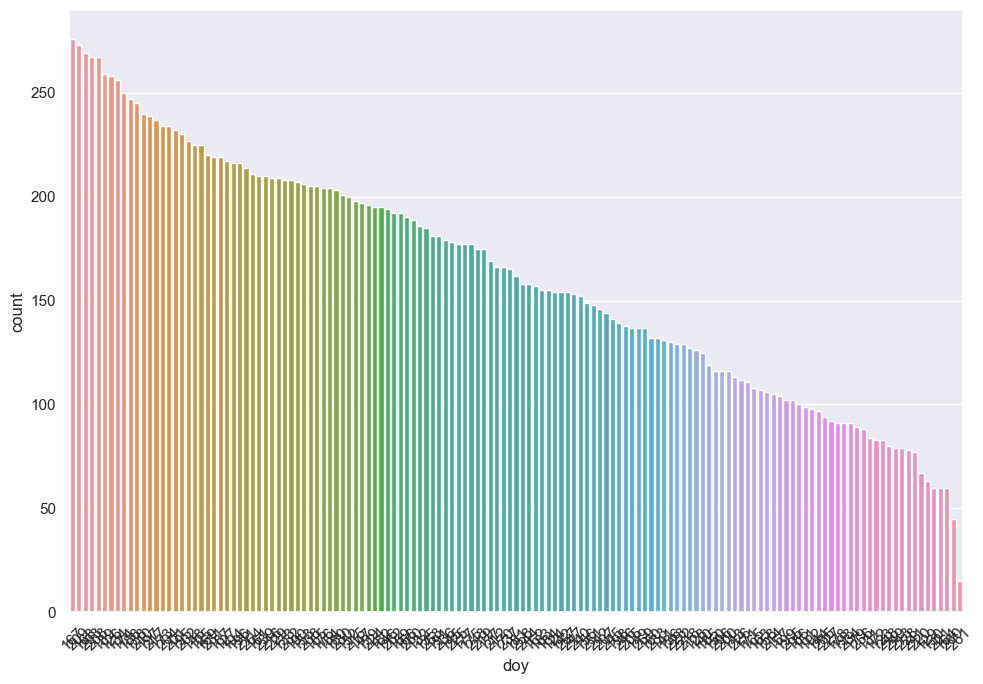

In [248]:
plt.figure(figsize=(10,7), dpi =100)
plot = sns.countplot(df[df['transactionid']>1]['doy'], order=df[df['transactionid']>1]['doy'].value_counts().index)
plot.set_xticklabels(plot.get_xticklabels(), rotation = 45)
plt.tight_layout()

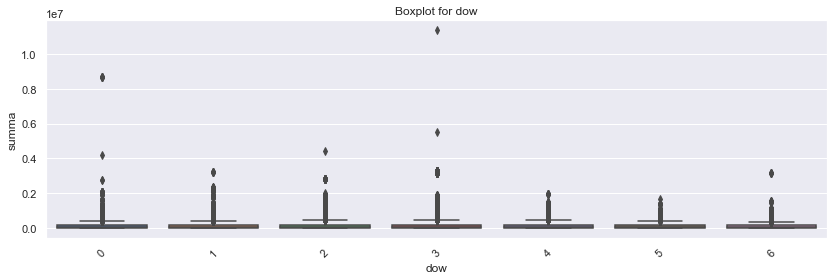

In [247]:
get_boxplot(df[df['transactionid']>1], 'dow', 'summa')

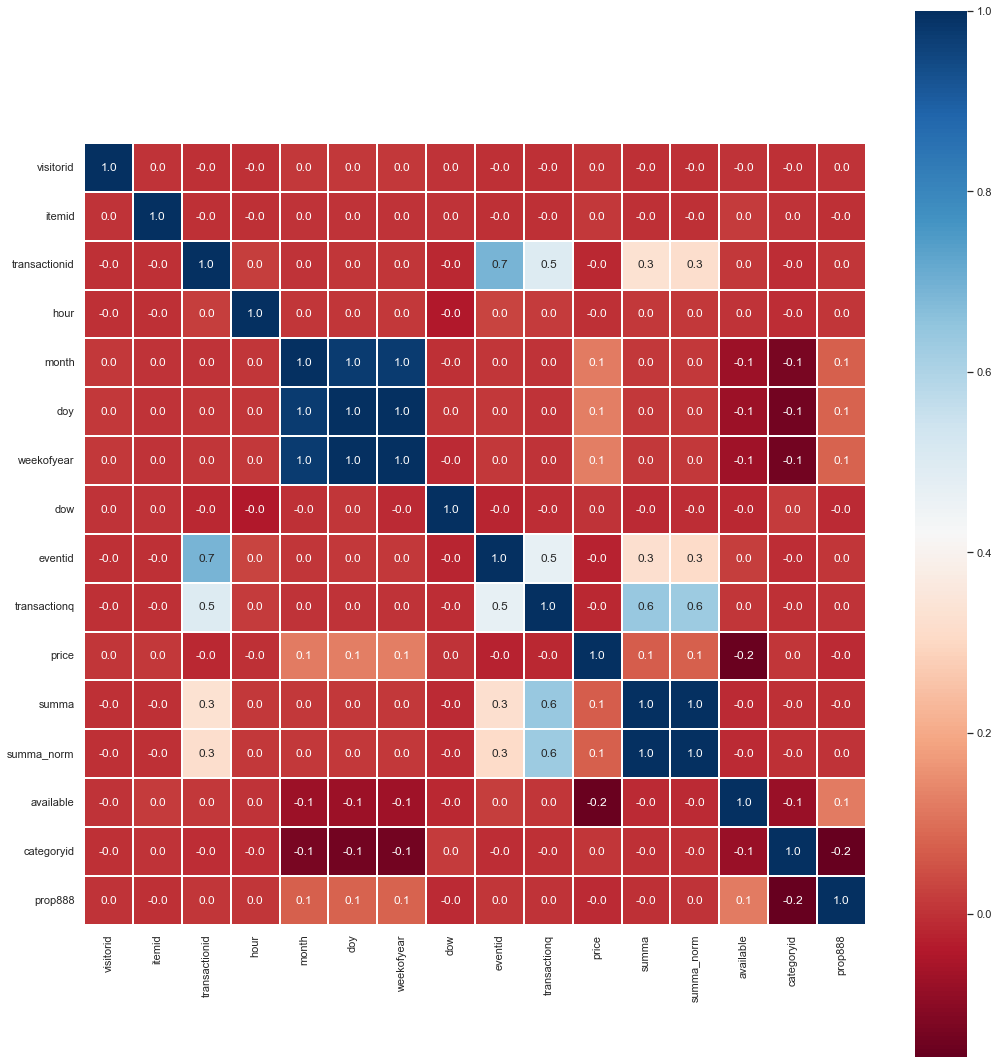

In [250]:
# рисуем тепловую карту необработанных значений
num_columns = [x for x in df.columns if not df[x].dtypes == 'object']
show_correlation(df, num_columns)

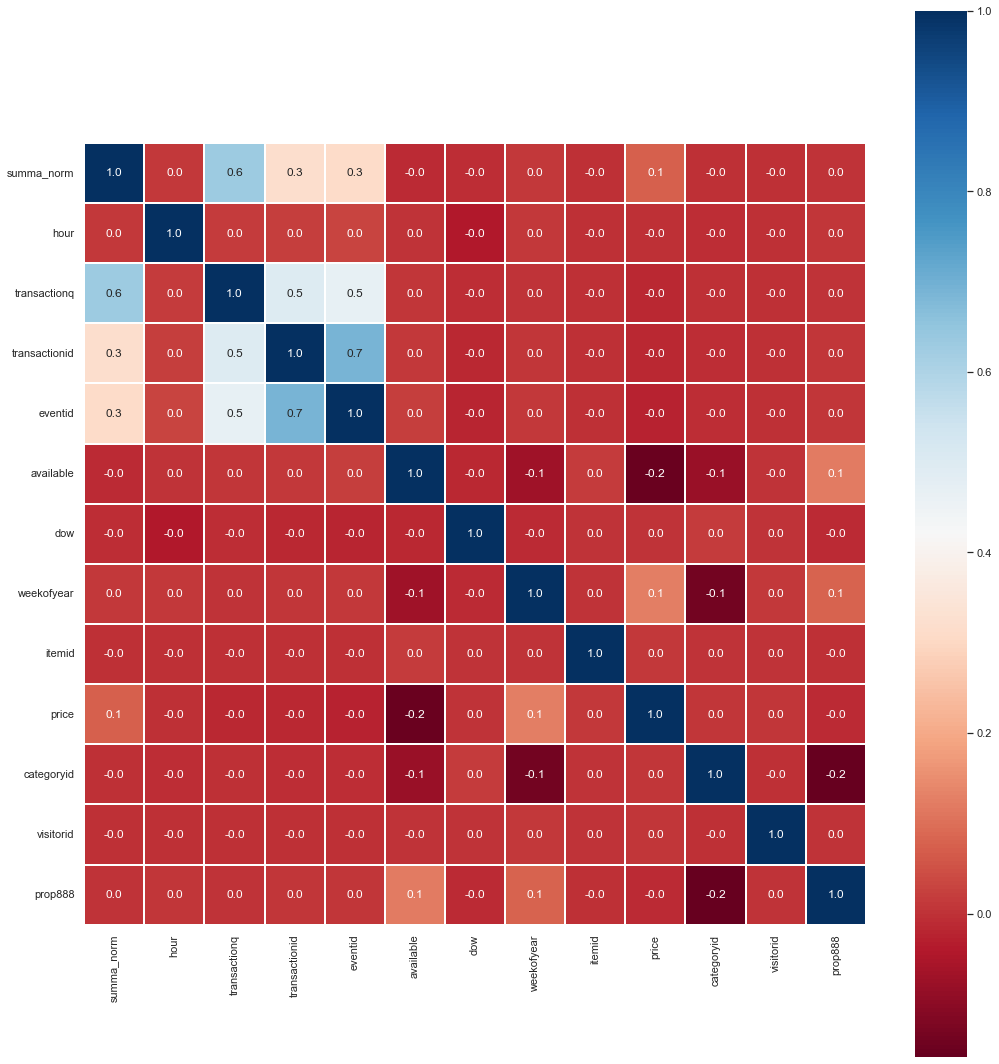

In [251]:
drop_collinear_features = ['month','doy','summa'] # 'number_of_reviews','indicator','price_range','quantity_rest','date_from_max']
                           
num_columns = list(set(num_columns)-set(drop_collinear_features))
show_correlation(df, num_columns)

In [254]:
most_correlated = df.corr().abs()['transactionq'].sort_values(ascending=False)
most_correlated

transactionq     1.000000
summa            0.638268
summa_norm       0.630530
transactionid    0.497742
eventid          0.466668
price            0.015225
hour             0.014809
available        0.008702
dow              0.008078
categoryid       0.003403
doy              0.003353
month            0.003249
weekofyear       0.003198
itemid           0.002950
prop888          0.001738
visitorid        0.000783
Name: transactionq, dtype: float64

# LightFM

In [59]:
from lightfm import LightFM
import scipy

C:\Users\Nata\Anaconda3\envs\TimeSeries\lib\site-packages\lightfm\_lightfm_fast.py:10: UserWarning: LightFM was compiled without OpenMP support. Only a single thread will be used.
  "LightFM was compiled without OpenMP support. "


In [60]:
df.head(10)

,doy,visitorid,itemid,view,addtocart,transaction,rating
0,123,385,47324,1.0,0.0,0.0,0.0
1,123,1819,127969,1.0,0.0,0.0,0.0
2,123,2231,340329,1.0,0.0,0.0,0.0
3,123,2337,218126,1.0,0.0,0.0,0.0
4,123,3194,277139,1.0,0.0,0.0,0.0
5,123,3902,434171,1.0,0.0,0.0,0.0
6,123,3997,158114,1.0,0.0,0.0,0.0
7,123,4233,144540,1.0,0.0,0.0,0.0
8,123,4991,96883,1.0,0.0,0.0,0.0
9,123,4991,372845,1.0,0.0,0.0,0.0


In [79]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 674732 entries, 0 to 674731
Data columns (total 5 columns):
 #   Column     Non-Null Count   Dtype
---  ------     --------------   -----
 0   doy        674732 non-null  int16
 1   rating     674732 non-null  int16
 2   itemid     674732 non-null  int32
 3   visitorid  674732 non-null  int32
 4   score      674732 non-null  int16
dtypes: int16(3), int32(2)
memory usage: 14.2 MB


In [62]:
df = df[['doy', 'rating', 'itemid', 'visitorid']].copy()
df['doy'] = df['doy'].astype('int16')
df['rating'] = df['rating'].astype('int16')
df['itemid'] = df['itemid'].astype('int32')
df['visitorid'] = df['visitorid'].astype('int32')

arr_range = df['doy'].unique().tolist()
#for i in range(arr_range[0], arr_range[-1],9):
#  print(i, i+9-1)
df.sort_values('doy', inplace=True)

df['score'] = (df['rating'] > 20).apply('int16')
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 674732 entries, 0 to 674731
Data columns (total 5 columns):
 #   Column     Non-Null Count   Dtype
---  ------     --------------   -----
 0   doy        674732 non-null  int16
 1   rating     674732 non-null  int16
 2   itemid     674732 non-null  int32
 3   visitorid  674732 non-null  int32
 4   score      674732 non-null  int16
dtypes: int16(3), int32(2)
memory usage: 14.2 MB


In [78]:
df.doy.unique()

array([123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135,
       136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148,
       149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161,
       162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174,
       175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187,
       188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200,
       201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213,
       214, 215, 216, 217, 218, 219, 220, 221, 222, 223, 224, 225, 226,
       227, 228, 229, 230, 231, 232, 233, 234, 235, 236, 237, 238, 239,
       240, 241, 242, 243, 244, 245, 246, 247, 248, 249, 250, 251, 252,
       253, 254, 255, 256, 257, 258, 259, 260, 261], dtype=int16)

In [67]:
arr_range = df['doy'].unique().tolist()
for i in range(arr_range[0], arr_range[-1],9):
  print(i, i+9-1)

123 131
132 140
141 149
150 158
159 167
168 176
177 185
186 194
195 203
204 212
213 221
222 230
231 239
240 248
249 257
258 266


In [86]:
arr_range = df['doy'].unique().tolist()
for i in range(0,len(arr_range),9):
    print(i)
    start = arr_range[i]
    if (i+8) < len(arr_range)-1:
        end = arr_range[i+8]
    else:
        end = arr_range[-1]

    ratings = df[(df.doy>=start)&(df.doy<=end)]
    train = ratings[(ratings.doy>=start)&(ratings.doy<end)]
    test = ratings[ratings.doy==end]

    train_pivot = pd.pivot_table(
        train,
        index="visitorid", 
        columns="itemid", 
        values="score"
        )
    test_pivot = pd.pivot_table(
        test,
        index="visitorid", 
        columns="itemid", 
        values="score"
        )

    print(train_pivot.shape)
    print(test_pivot.shape)
    ## (751, 1616)
    ## (301, 1448)

    shell = pd.pivot_table(
        ratings, 
        index="visitorid", 
        columns="itemid", 
        values="score", 
        aggfunc=lambda x: 0
        )

    train_pivot = shell + train_pivot
    test_pivot = shell + test_pivot

    train_pivot = (train_pivot + 1).fillna(0)
    test_pivot = (test_pivot + 1).fillna(0)
    print(train_pivot.shape)
    print(test_pivot.shape)
    ## (943, 1682)
    ## (943, 1682)


    train_pivot_sparse = scipy.sparse.csr_matrix(train_pivot.values)
    test_pivot_sparse = scipy.sparse.csr_matrix(test_pivot.values)

    model = AlternatingLeastSquares(factors=3, random_state=42)
    model.fit(train_pivot_sparse)

    unique_items = np.array(train_pivot.columns)
    user_id = 14
    recomendations_ids, scores = model.recommend(user_id, train_pivot_sparse[user_id])
    recomendations = unique_items[recomendations_ids]
    print('Recomendations ids: {}'.format(recomendations_ids))
    print('Recomendations for user {}: {}'.format(user_id, recomendations))

    ## Recomendations ids: [293 116  99 275 244 287 283 150 125 596]
    ## Recomendations for user 14: [294 117 100 276 245 288 284 151 126 597]

    map_at10 = mean_average_precision_at_k(model, train_pivot_sparse, test_pivot_sparse, K=3)
    print('Mean Average Precision at 10: {:.10f}'.format(map_at10))

    ## Mean Average Precision at 10: 0.087


0
(22652, 7040)
(2721, 2263)
(25070, 7255)
(25070, 7255)


100%|██████████| 15/15 [00:00<00:00, 82.87it/s]


Recomendations ids: [5761 1847  772  550 4973 5688 3251 5309 3054 2307]
Recomendations for user 14: [369447 119736  51354  37029 320130 365015 210087 340921 198209 150882]


100%|██████████| 2721/2721 [00:00<00:00, 6006.63it/s]


Mean Average Precision at 10: 0.0007350239
9
(29063, 7695)
(3693, 2842)
(32200, 7948)
(32200, 7948)


100%|██████████| 15/15 [00:00<00:00, 34.40it/s]


Recomendations ids: [ 592 6638 5436 5383 3641 4705 5368 6315  798 2019]
Recomendations for user 14: [ 37029 387373 318333 315543 215596 274435 314789 369158  49544 119736]


100%|██████████| 3693/3693 [00:00<00:00, 5603.95it/s]


Mean Average Precision at 10: 0.0005415651
18
(26560, 7268)
(3564, 2733)
(29657, 7510)
(29657, 7510)


100%|██████████| 15/15 [00:00<00:00, 76.53it/s]


Recomendations ids: [4995 4105 5797 5783  888 1901 5060 7340 6170 5354]
Recomendations for user 14: [309778 257040 359844 358895  57245 119736 314789 456056 382751 334273]


100%|██████████| 3564/3564 [00:00<00:00, 6624.53it/s]


Mean Average Precision at 10: 0.0003507295
27
(26353, 7283)
(2747, 2362)
(28788, 7468)
(28788, 7468)


100%|██████████| 15/15 [00:00<00:00, 93.76it/s]


Recomendations ids: [4982 1904 4115 3728 5922 5108 5699 2375 7294 6760]
Recomendations for user 14: [309778 119736 257040 234255 369158 318333 355994 150882 456056 420960]


100%|██████████| 2747/2747 [00:00<00:00, 7025.60it/s]


Mean Average Precision at 10: 0.0003033612
36
(24923, 7558)
(4294, 3341)
(28703, 7935)
(28703, 7935)


100%|██████████| 15/15 [00:00<00:00, 78.13it/s]


Recomendations ids: [9 8 7 6 5 4 3 2 1 0]
Recomendations for user 14: [572 563 496 403 320 233 147  42  25  15]


100%|██████████| 4294/4294 [00:00<00:00, 5858.13it/s]


Mean Average Precision at 10: 0.0002199451
45
(27187, 7889)
(3615, 2918)
(30327, 8140)
(30327, 8140)


100%|██████████| 15/15 [00:00<00:00, 72.47it/s]


Recomendations ids: [5418 4802 1938 3556 1531 1844  673 1135 7714 2536]
Recomendations for user 14: [309778 274798 111530 206241  89775 106547  40140  67533 441966 148855]


100%|██████████| 3615/3615 [00:00<00:00, 6085.86it/s]


Mean Average Precision at 10: 0.0004303058
54
(25683, 7673)
(2708, 2372)
(28109, 7918)
(28109, 7918)


100%|██████████| 15/15 [00:00<00:00, 98.69it/s]


Recomendations ids: [ 779 3897 2002 7446 6311 5333 7728 1160 1840 2687]
Recomendations for user 14: [ 48030 231482 119736 439963 372169 314201 456056  70314 109109 161623]


100%|██████████| 2708/2708 [00:00<00:00, 7279.59it/s]


Mean Average Precision at 10: 0.0003692762
63
(28042, 7885)
(4498, 3298)
(32075, 8208)
(32075, 8208)


100%|██████████| 15/15 [00:00<00:00, 44.59it/s]


Recomendations ids: [8125  819 7342 7992 2080 7414 5931  829 6944 1225]
Recomendations for user 14: [461686  48030 416017 454422 119736 420960 338395  48378 393028  71733]


100%|██████████| 4498/4498 [00:00<00:00, 6713.43it/s]


Mean Average Precision at 10: 0.0000741070
72
(28205, 7913)
(4132, 3116)
(31818, 8189)
(31818, 8189)


100%|██████████| 15/15 [00:00<00:00, 72.46it/s]


Recomendations ids: [7804 6738 2056 3680  289 3801 8095 1515 5902  191]
Recomendations for user 14: [445351 384302 119736 213834  17478 219512 461686  89323 338395  11279]


100%|██████████| 4132/4132 [00:00<00:00, 5953.90it/s]


Mean Average Precision at 10: 0.0006453695
81
(29817, 7934)
(3513, 2769)
(32891, 8201)
(32891, 8201)


100%|██████████| 15/15 [00:00<00:00, 47.01it/s]


Recomendations ids: [7823  629    9 4361 3714 7390 2076 2593  802 7312]
Recomendations for user 14: [445351  37029    546 248455 213834 420960 119736 149582  48030 416017]


100%|██████████| 3513/3513 [00:00<00:00, 6375.69it/s]


Mean Average Precision at 10: 0.0001897713
90
(25005, 7421)
(2202, 1961)
(26964, 7618)
(26964, 7618)


100%|██████████| 15/15 [00:00<00:00, 96.15it/s]


Recomendations ids: [3554 7535  156 1942   10 3006 2084 4037 6892 5240]
Recomendations for user 14: [219512 461686   9877 119736    546 186702 128745 248455 420960 320130]


100%|██████████| 2202/2202 [00:00<00:00, 6946.41it/s]


Mean Average Precision at 10: 0.0006559693
99
(23408, 7245)
(3876, 2814)
(26828, 7565)
(26828, 7565)


100%|██████████| 15/15 [00:00<00:00, 101.37it/s]


Recomendations ids: [3547 6231 7473 3054 1928 5970 4164 6360 1846 4220]
Recomendations for user 14: [219512 384302 461686 190000 119736 368488 257040 391226 114070 259962]


100%|██████████| 3876/3876 [00:00<00:00, 7111.94it/s]


Mean Average Precision at 10: 0.0003439972
108
(24121, 7305)
(3645, 2679)
(27357, 7610)
(27357, 7610)


100%|██████████| 15/15 [00:00<00:00, 87.21it/s]


Recomendations ids: [4012    9 7522 2006 4935 4113  712 6753  769 4623]
Recomendations for user 14: [248455    546 461686 125831 303178 254290  46126 414428  49418 284312]


100%|██████████| 3645/3645 [00:00<00:00, 6591.33it/s]


Mean Average Precision at 10: 0.0002591068
117
(23581, 7012)
(2546, 2062)
(25882, 7234)
(25882, 7234)


100%|██████████| 15/15 [00:00<00:00, 107.16it/s]


Recomendations ids: [4963 4635 4725 7150 2428 5253 6777 6823 5530 1149]
Recomendations for user 14: [320130 298056 303715 461686 158666 338660 438484 441668 355994  76060]


100%|██████████| 2546/2546 [00:00<00:00, 7316.12it/s]


Mean Average Precision at 10: 0.0004909662
126
(25571, 7052)
(3690, 2600)
(28884, 7324)
(28884, 7324)


100%|██████████| 15/15 [00:00<00:00, 101.36it/s]


Recomendations ids: [3829 7239 2969 3098 6363 7230  677 1858 5312 3432]
Recomendations for user 14: [245085 461686 190000 198784 405380 461190  46130 119736 338395 219512]


100%|██████████| 3690/3690 [00:00<00:00, 6936.08it/s]


Mean Average Precision at 10: 0.0005420054
135
(6901, 4003)
(270, 299)
(7121, 4059)
(7121, 4059)


100%|██████████| 15/15 [00:00<00:00, 272.73it/s]


Recomendations ids: [2751   81 2073 2846 3621  329  780 3197 2753 1849]
Recomendations for user 14: [314579   9877 241555 325310 416357  38965  91235 363125 314801 215051]


100%|██████████| 270/270 [00:00<00:00, 6279.46it/s]

Mean Average Precision at 10: 0.0000000000


<AxesSubplot:>

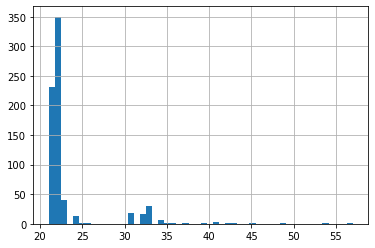

In [102]:
# Смотрим по рейтингу, что покупалось более 1 раза: покупка оценивается 10 баллов,
# значит yfc bynthtcetn htqnbyu >20
df[df.rating>20].rating.hist(bins=50)

In [124]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 674732 entries, 0 to 674731
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype
---  ------     --------------   -----
 0   doy        674732 non-null  int16
 1   rating     674732 non-null  int16
 2   itemid     674732 non-null  int32
 3   visitorid  674732 non-null  int32
dtypes: int16(2), int32(2)
memory usage: 12.9 MB


In [127]:
train

,doy,rating,itemid,visitorid
0,123,0,47324,385
2142,123,0,40140,896779
2143,123,0,266439,896855
2144,123,0,82340,897623
2145,123,0,457231,898453
...,...,...,...,...
660240,259,0,24150,76415
660239,259,0,445780,75145
660238,259,11,57830,73292
660237,259,0,303715,73192


In [123]:
df.drop(['score'], axis=1, inplace=True)

In [125]:
train = df[df.doy<260].copy()
test = df[df.doy==260]
# Лисицкая

In [128]:
df0 = train[['itemid', 'visitorid', 'rating']].copy()
#df0.drop(['doy','score'], axis=1,inplace=True)

In [129]:
df0

,itemid,visitorid,rating
0,47324,385,0
2142,40140,896779,0
2143,266439,896855,0
2144,82340,897623,0
2145,457231,898453,0
...,...,...,...
660240,24150,76415,0
660239,445780,75145,0
660238,57830,73292,11
660237,303715,73192,0


In [130]:
train_pivot = pd.pivot_table(
    train[['itemid', 'visitorid', 'rating']],
    index="visitorid", 
    columns="itemid", 
    values="rating"
    )
test_pivot = pd.pivot_table(
    test[['itemid', 'visitorid', 'rating']],
    index="visitorid", 
    columns="itemid", 
    values="rating"
    )

print(train_pivot.shape)
print(test_pivot.shape)

IndexError: index 607570610 is out of bounds for axis 0 with size 607566200

In [118]:
df1 = df0.groupby(['visitorid','itemid'])[['rating']].sum()
df1.reset_index(inplace=True)
df1

,visitorid,itemid,rating
0,0,67045,0
1,0,357564,0
2,2,216305,0
3,2,259884,0
4,2,325215,0
...,...,...,...
619354,1407562,337671,0
619355,1407572,122041,0
619356,1407573,82278,0
619357,1407573,363109,0


In [120]:
# для этого воспользуемся функцией pivot и создадим сводную таблицу (pivot table)
# по горизонтали будут продукты по вертикали - пользователи, значения - оценки
user_item_matrix = df1.pivot(index = 'itemid', columns = 'visitorid', values= 'rating')
user_item_matrix.head()

IndexError: index 627181805 is out of bounds for axis 0 with size 627129754

In [107]:
# вначале сгруппируем (объединим) пользователей, возьмем только столбец rating 
# и посчитаем, сколько было оценок у каждого пользователя
users_votes = df0.groupby('visitorid')['rating'].agg('count')

# сделаем то же самое, только для продукта
item_votes = df0.groupby('itemid')['rating'].agg('count')

In [110]:
# теперь создадим фильтр (mask)
user_mask = users_votes[users_votes > 20].index
item_mask = item_votes[item_votes > 20].index